# RibonanzaNet-Deg
- https://www.kaggle.com/code/shujun717/ribonanzanet-deg

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

## Define Variables

In [2]:
data_folder = "/Users/person/codeScope/BEHI/openvaccine_playground/stanford-covid-vaccine"

## Define Dataset

In [3]:
from torch.utils.data import Dataset, DataLoader

class RNA2D_Dataset(Dataset):
    def __init__(self,data):
        self.data=data
        self.tokens={nt:i for i,nt in enumerate('ACGU')}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence=[self.tokens[nt] for nt in self.data.loc[idx,'sequence']]
        sequence=np.array(sequence)
        sequence=torch.tensor(sequence)

        return {'sequence':sequence}

In [4]:
test_data=pd.read_json(f"{data_folder}/test.json",lines=True)
test_dataset=RNA2D_Dataset(test_data)
test_dataset[0]

{'sequence': tensor([2, 2, 0, 0, 0, 0, 2, 3, 0, 1, 2, 0, 1, 3, 3, 2, 0, 2, 3, 0, 1, 2, 2, 0,
         0, 0, 0, 1, 2, 3, 0, 1, 1, 0, 0, 1, 3, 1, 2, 0, 3, 3, 0, 0, 0, 0, 3, 2,
         2, 3, 1, 0, 0, 0, 2, 0, 2, 2, 3, 1, 2, 0, 0, 0, 3, 0, 1, 0, 2, 0, 3, 2,
         0, 1, 1, 3, 3, 1, 2, 2, 2, 3, 3, 0, 3, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0,
         0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])}

In [5]:
len(test_data)

3634

In [8]:
import sys
sys.path.append("/Users/person/codeScope/BEHI/openvaccine_playground/benchmark/RibonanzaNet2D_Final")

In [9]:
from Network import *
import yaml

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        self.entries=entries

    def print(self):
        print(self.entries)

def load_config_from_yaml(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return Config(**config)

class finetuned_RibonanzaNet(RibonanzaNet):
    def __init__(self, config):
        super(finetuned_RibonanzaNet, self).__init__(config)

        self.decoder = nn.Linear(config.ninp,5)
        
    def forward(self,src):
        
        sequence_features, pairwise_features=self.get_embeddings(src, torch.ones_like(src).long().to(src.device))

        output=self.decoder(sequence_features) #predict

        return output#.squeeze(-1)

In [12]:
model=finetuned_RibonanzaNet(load_config_from_yaml("/Users/person/codeScope/BEHI/openvaccine_playground/benchmark/RibonanzaNet2D_Final/configs/pairwise.yaml"))
model.load_state_dict(torch.load("/Users/person/codeScope/BEHI/openvaccine_playground/benchmark/RibonanzaNet-Deg.pt",map_location='cpu'))

constructing 9 ConvTransformerEncoderLayers


<All keys matched successfully>

## Make predictions

In [13]:
from tqdm import tqdm

test_preds=[]
model.eval()
for i in tqdm(range(len(test_dataset))):
    example=test_dataset[i]
    sequence=example['sequence'].unsqueeze(0)

    with torch.no_grad():
        test_preds.append(model(sequence).cpu().numpy())

  0%|                                                                      | 0/3634 [00:00<?, ?it/s]/Users/person/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/person/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|█████████████████████████████████████████████████████████| 3634/3634 [1:20:11<00:00,  1.32s/it]


In [14]:
test_preds[0].shape

(1, 107, 5)

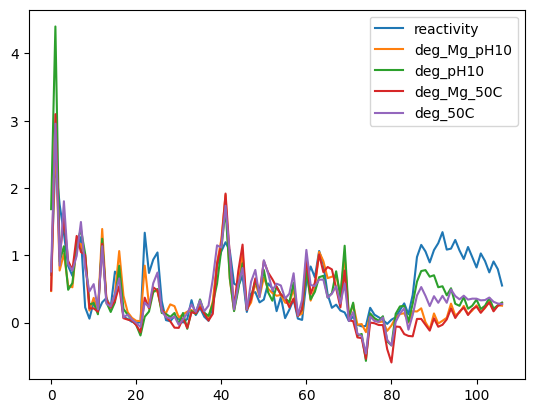

In [15]:
import matplotlib.pyplot as plt
labels=['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
for i in range(5):
    
    plt.plot(test_preds[0][0,:,i],label=labels[i])
    
plt.legend()

In [16]:
preds=[]
ids=[]
for i in range(len(test_data)):
    preds.append(test_preds[i][0,:])
    id=test_data.loc[i,'id']
    ids.extend([f"{id}_{pos}" for pos in range(len(test_preds[i][0,:]))])
    #break
preds=np.concatenate(preds)
preds.shape

(457953, 5)

In [17]:
sub=pd.DataFrame()

sub['id_seqpos']=ids

for i,l in enumerate(['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']):
    sub[l]=preds[:,i]
sub.to_csv('submission.csv',index=False)